In [1]:
import numpy as np
from mnist import MNIST
import matplotlib
matplotlib.use("nbagg")
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import time

In [2]:
# Load input data
# The data loaded here has shape (25000, 2). The variable is in the index 1. Index 0 appears to be time
data0 = np.loadtxt("l96/henry_data/lor9654_0_1.dat")
data1 = np.loadtxt("l96/henry_data/lor9654_0_01.dat")
data2 = np.loadtxt("l96/henry_data/lor9654_0_001.dat")

var1 = data1[:, 1]
var1_norm = var1 / max(var1)

<IPython.core.display.Javascript object>


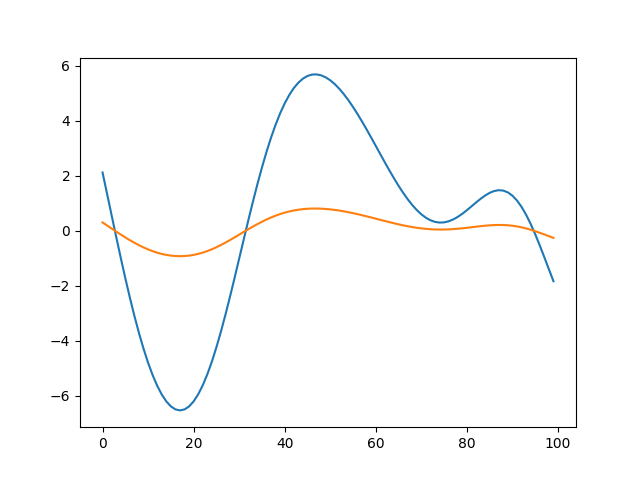

In [3]:
plt.plot(var1[0:100])
plt.plot(var1_norm[0:100])
plt.show()

In [4]:
#Architecture & Hyperparameters
layer_in = 4
layer1 = 10
layer_out = 1
alpha = 0.01

In [5]:
# Subset Samples for training, validation
np.random.seed(1)

# Construct the proper lengths for the input and output
num_ex = 200
x_all = np.empty(shape=(num_ex, layer_in))
y_all = np.empty(shape=(num_ex, layer_out))
for i in xrange(num_ex):
    x_all[i, :] = var1[i:i+layer_in]
    y_all[i, :] = var1[i+layer_in:i+layer_in+layer_out]
# for i in xrange(num_ex):
#     x_all[i, :] = var1_norm[i:i+layer_in]
#     y_all[i, :] = var1_norm[i+layer_in:i+layer_in+layer_out]

    

# For now, choose first few for training, later it's better to choose a random sample
train_examples = int(0.5*num_ex)
x_train = x_all[0:train_examples,:]
y_train = y_all[0:train_examples,:]

In [11]:
x_all.shape

(200, 4)

<IPython.core.display.Javascript object>


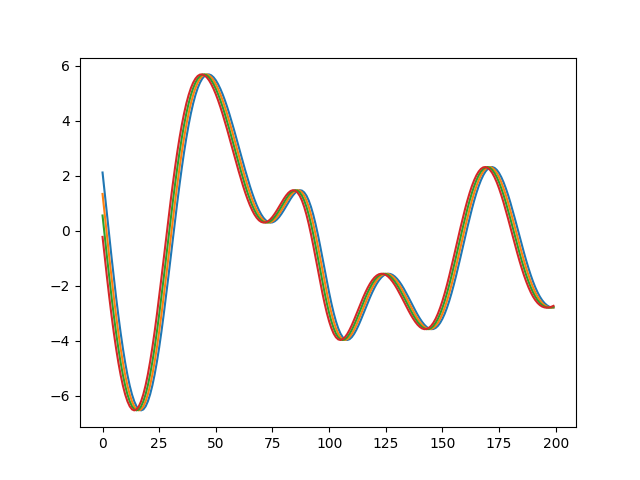

In [6]:
plt.plot(x_all)
plt.show()

In [8]:
def sigmoid(x, deriv=False):
    if deriv:
        return x * (1 - x)
    else:
        return 1 / (1 + np.exp(-x))

In [9]:
np.random.seed(1)
#Input -> l1 Weight matrix has to be np.shape = (6, 20) extra bias term
w1 = 2*np.random.random((layer_in + 1, layer1)) - 1

#l1 -> Output Weight matrix has to be np.shape = (21, 4) extra bias term
w2 = 2*np.random.random((layer1 + 1, layer_out)) - 1
#Training
tot_error = 1
counter = 0

tstart = time.time()
iterations = 10000
# batch_size controls how many examples the training algorithm uses each time
batch_size = 10
while (counter < iterations):

    # randomize which part of the training set we use
    train_idx = np.random.randint(0, train_examples, size=(batch_size))
    
    # forward prop
    # load in input & label
    x0 = np.hstack((np.ones((batch_size,1)), x_train[train_idx,:]))
    y = y_train[train_idx,:] 
    
    # propagate forward 
    x1 = np.hstack((np.ones((batch_size,1)), sigmoid(w1.T.dot(x0.T)).T)) # vector length 201
    x2 = w2.T.dot(x1.T).T # vector length 10

    # backprop
    # calculate errors
    tot_error = sum(sum((x2 - y)**2 / (2 * batch_size)))
    l2_delta = (x2 - y) # matrix shape (10,n)
    l1_delta = sigmoid(x1[:,1:], True)*(w2[1:,:].dot(l2_delta.T).T)
    
    # calculate gradients
    l2_grad = l2_delta[:, :, np.newaxis].T * x1[:, np.newaxis, :].T
    l1_grad = l1_delta[:, :, np.newaxis].T * x0[:, np.newaxis, :].T
    
    # find total gradient across all examples
    l2_totgrad = np.average(l2_grad, axis=2) # matrix shape (101,10)
    l1_totgrad = np.average(l1_grad, axis=2) # matrix shape (785,200)
    
    if counter % 1000 == 0:
        print ("Iteration %d, Error: %f" % (counter, tot_error))
    counter += 1
        
    # update weights
    w2 += -alpha*l2_totgrad/np.sqrt(counter) # update weight 2 -> 3
    w1 += -alpha*l1_totgrad/np.sqrt(counter) # update weight 1 -> 2
        
print ("Training to %f error rate took %d seconds." % (tot_error, time.time()-tstart))

Iteration 0, Error: 5.871537
Iteration 1000, Error: 2.203130
Iteration 2000, Error: 0.931948
Iteration 3000, Error: 1.246624
Iteration 4000, Error: 0.721353
Iteration 5000, Error: 1.250915
Iteration 6000, Error: 1.063860
Iteration 7000, Error: 1.158577
Iteration 8000, Error: 0.984358
Iteration 9000, Error: 0.920759
Training to 0.551359 error rate took 1 seconds.


In [237]:
np.random.seed(1)
#Input -> l1 Weight matrix has to be np.shape = (layer_in + 1, layer1) extra bias term
w01 = 2*np.random.random((layer_in + 1, layer1)) - 1

#l1 -> Output Weight matrix has to be np.shape = (layer_1 + 1, layer_out) extra bias term
w12 = 2*np.random.random((layer1 + 1, layer_out)) - 1
#Training
tot_error = 1
counter = 0

tstart = time.time()
iterations = 10000
# batch_size controls how many examples the training algorithm uses each time
batch_size = 2
while (counter < iterations):

    # randomize which part of the training set we use
    train_idx = np.random.randint(0, train_examples, size=(batch_size))

    # forward prop
    # load in input & label
    x0 = np.vstack((np.ones((batch_size)), x_train[train_idx,:].T)) # shape (layer_in + 1, batch_size)
    y = y_train[train_idx,:].T # shape (layer_out, batch_size)

    # propagate forward 
    x1 = np.vstack((np.ones((batch_size)), sigmoid(w01.T.dot(x0)))) # shape (layer_1 + 1, batch_size)
    x2 = w12.T.dot(x1) # shape (layer_out, batch_size)

    # backprop
    # calculate errors
    tot_error = sum(sum((x2 - y)**2 / (2 * batch_size)))
    l2_delta = (x2 - y) # shape (layer_out, batch_size)
    l1_delta = sigmoid(x1, True) * (w2.dot(l2_delta)) # shape (layer_1 + 1, batch_size)

    # calculate gradients
    l2_grad = l2_delta[np.newaxis, :, :] * x1[:, np.newaxis, :] # shape (layer_1 + 1, layer_out, batch_size)
    l1_grad = l1_delta[np.newaxis, 1:, :] * x0[:, np.newaxis, :] # shape (layer_in + 1, layer_1, batch_size)

    # find total gradient across all examples
    l2_totgrad = np.average(l2_grad, axis=2) # shape (layer_1 + 1, layer_out)
    l1_totgrad = np.average(l1_grad, axis=2) # shape (layer_in + 1, layer_1)

    if counter % 1000 == 0:
        print ("Iteration %d, Error: %f" % (counter, tot_error))
    counter += 1

    # update weights
    w12 += -alpha*l2_totgrad/np.sqrt(counter) # update weight 1 -> out
    w01 += -alpha*l1_totgrad/np.sqrt(counter) # update weight in -> 1
        
print ("Training to %f error rate took %d seconds." % (tot_error, time.time()-tstart))

Iteration 0, Error: 8.573440
Iteration 1000, Error: 3.411450
Iteration 2000, Error: 0.001581
Iteration 3000, Error: 1.024728
Iteration 4000, Error: 2.399201
Iteration 5000, Error: 1.123766
Iteration 6000, Error: 2.839991
Iteration 7000, Error: 2.507118
Iteration 8000, Error: 0.475966
Iteration 9000, Error: 1.132494
Training to 0.690265 error rate took 2 seconds.


In [239]:
# Validation
def validate():
    # might be a crude way of defining our validation set
    batch_size = num_ex - train_examples
    val_idx = np.random.randint(train_examples, num_ex, size=(batch_size))
    
    x0 = np.vstack((np.ones((batch_size)), x_all[val_idx,:].T)) # shape (layer_in + 1, batch_size)
    y = y_all[val_idx,:].T # shape (layer_out, batch_size)

    # propagate forward 
    x1 = np.vstack((np.ones((batch_size)), sigmoid(w01.T.dot(x0)))) # shape (layer_1 + 1, batch_size)
    x2 = w12.T.dot(x1) # shape (layer_out, batch_size)

    # backprop
    # calculate errors
    tot_error = sum(sum((x2 - y)**2 / (2 * batch_size)))
    return tot_error

In [244]:
validate()

0.42210969090733774

In [257]:
def predict(t_start, time_steps, data):
    prediction_window = np.arange(t_start, t_start + time_steps)
    x_true = data[0:t_start + time_steps, np.newaxis]
    x_predict = data[0:t_start + time_steps, np.newaxis]
    for i in xrange(time_steps):
        if i == 0:
            x0 = np.vstack(([1], data[t_start - layer_in:t_start, np.newaxis]))
        elif (i < layer_in):
            x0 = np.vstack(([[1]], x0[2:layer_in - i + 2], x_predict[0:i]))
        else:
            x0 = np.vstack(([1], x_predict[i-layer_in:i]))
        
        x1 = np.vstack(([1], sigmoid(w01.T.dot(x0)))) # shape (layer_1 + 1, 1)
        x2 = w12.T.dot(x1) # shape (layer_out, 1)
        print(x2[0])
        x_predict[t_start + i] = x2[0]
    print("Root mean square error: %f" % (np.sqrt(sum(x_predict[prediction_window] - x_true[prediction_window])**2) / time_steps))
    return(x_true, x_predict)

In [258]:
true, prediction = predict(10,30, var1)
# print(true)
#print(prediction)

[-4.19411042]
[ 0.20513766]
[-2.29970069]
[-1.54177822]
[ 1.06716425]
[-0.12425853]
[-1.43813426]
[-2.51047202]
[-3.2938387]
[-3.84030804]
[-4.19411042]
[-4.21956479]
[-0.56797761]
[-4.45303557]
[-2.32663511]
[ 0.29373174]
[-3.0767069]
[-2.05792525]
[-1.60205978]
[-2.85275758]
[-3.73608763]
[-4.16836641]
[-4.29195787]
[-1.12149817]
[-4.71270367]
[-2.25875513]
[-0.93408994]
[-4.60943828]
[-1.68251537]
[-1.72419447]
Root mean square error: 0.000000


<IPython.core.display.Javascript object>


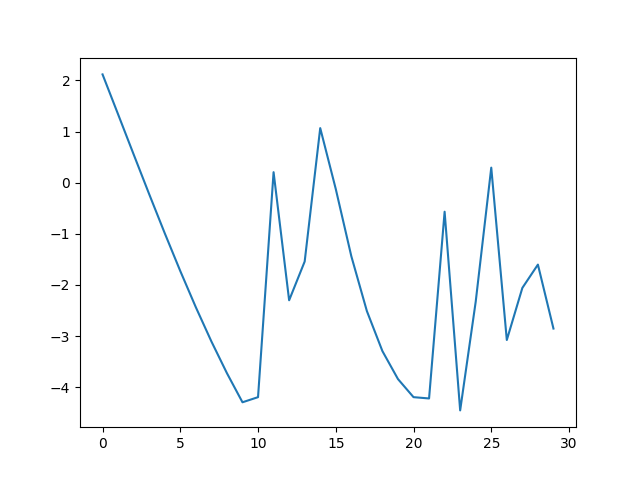

In [256]:
#plt.plot(true)
#plt.plot(prediction)
plt.plot(var1[0:30])
plt.show()